In [2]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

3D Reconstruction of crystalline dislocations.

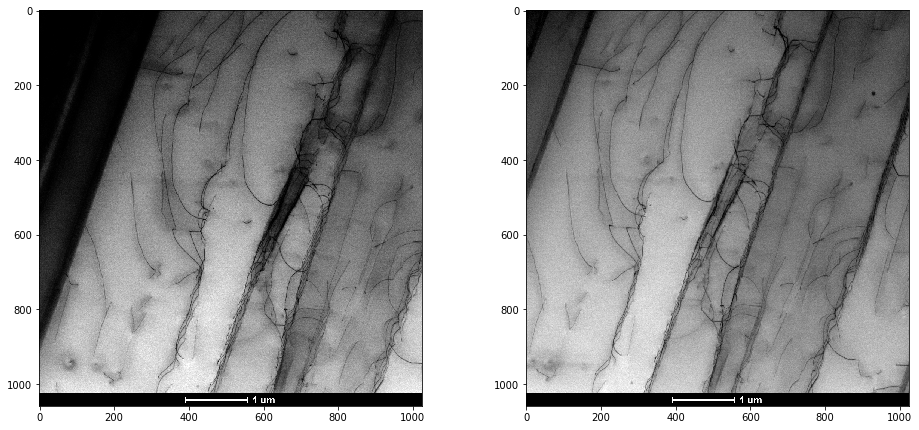

In [11]:
imgL = cv2.imread('/Users/altingovde/ws_local/dislocations/data/tilt_series_1/2_1024x1024_a=-2.08_BF.tif',0)
imgR = cv2.imread('/Users/altingovde/ws_local/dislocations/data/tilt_series_1/4_1024x1024_a=2.08_BF.tif',0)

fig = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(imgR, cmap='gray')
plt.show()

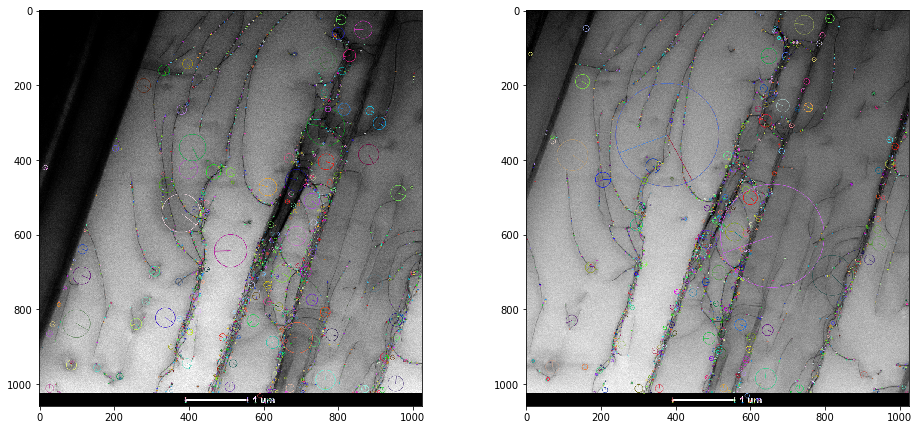

In [18]:
sift = cv2.xfeatures2d.SIFT_create()
kpL, desL = sift.detectAndCompute(imgL,None)
kpR, desR = sift.detectAndCompute(imgR,None)

kpimgL=cv2.drawKeypoints(imgL,kpL,imgL,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kpimgR=cv2.drawKeypoints(imgR,kpR,imgR,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.imshow(kpimgL, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(kpimgR, cmap='gray')
plt.show()

In [19]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desL,desR,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

[[ 1.00024308e+00 -5.46116243e-03 -1.27611841e+02]
 [ 5.46116243e-03  1.00024308e+00 -1.31587254e+01]]


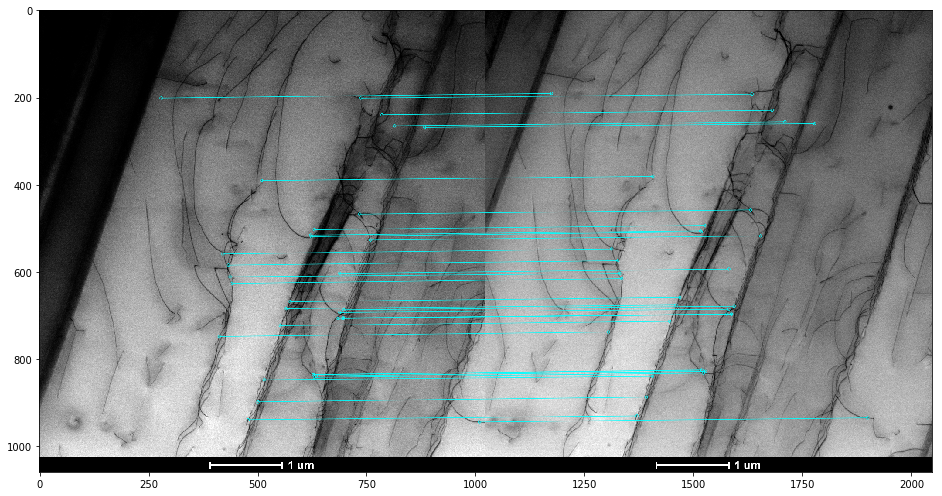

(<matplotlib.image.AxesImage at 0x122f2c8d0>, None)

In [30]:
# RANSAC to remove outliers
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
    matchesMask = mask.ravel().tolist()
    
print(M)
draw_params = dict(matchColor = (0,255,255), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
match_img = cv2.drawMatches(imgL,kpL,imgR,kpR,good,None,**draw_params)

fig = plt.figure(figsize=(16, 16))
plt.imshow(match_img, 'gray'),plt.show()

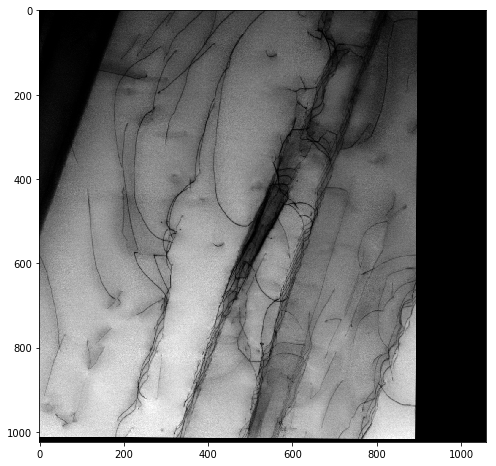

(<matplotlib.image.AxesImage at 0x1234b8d68>, None)

In [35]:
warped_imgL = cv2.warpAffine(imgL, M, imgL.shape)
fig = plt.figure(figsize=(8, 8))
plt.imshow(warped_imgL, 'gray'),plt.show()